## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* **Apply a perspective transform to rectify binary image ("birds-eye view").**
* **Detect lane pixels and fit to find the lane boundary.**
* **Determine the curvature of the lane and vehicle position with respect to center.**
* **Warp the detected lane boundaries back onto the original image.**
* **Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.**

---

## Apply a perspective transform to rectify binary image

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
ym_per_pix = 30 / 720
xm_per_pix = 3.7 / 700

In [3]:
parameters = pickle.load(open('./camera_calibration_parameters', 'rb'))
mtx, dist = map(parameters.get, ('mtx', 'dist'))

In [4]:
def region_lines(origin_img, vertices):
    img = origin_img.copy()
    for i in range(vertices.shape[1]-1):
        cv2.line(img, tuple(tuple(vertices[:, i])[0]), tuple(tuple(vertices[:, i+1])[0]), (0, 255, 0), 10)
    cv2.line(img, tuple(tuple(vertices[:, vertices.shape[1]-1])[0]), tuple(tuple(vertices[:, 0])[0]), (0, 255, 0), 10)
    return img

In [38]:
img = cv2.imread('../test_images/test3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undist = cv2.undistort(img, mtx, dist, None, mtx)
imshape = undist.shape
vertices = np.array([[(200, imshape[0]), (imshape[1]/2-40, imshape[0]*.6), 
               (imshape[1]/2+40, imshape[0]*.6), (1200, imshape[0])]], dtype=np.float32)

img_with_region_lines = region_lines(img, vertices)

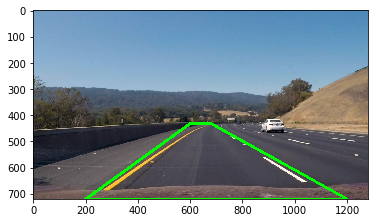

In [39]:
plt.imshow(img_with_region_lines)

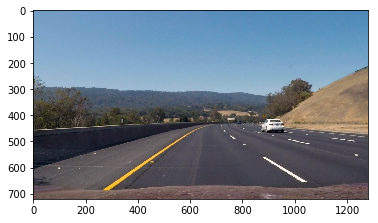

In [40]:
plt.imshow(img)

In [41]:
gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
src = vertices
X, Y = imshape[1], imshape[0]
offset = 200
dst = np.float32([
    (offset, Y),
    (offset, 0),
    (X-offset, 0),
    (X-offset, Y)
])
print (src)
print (dst)

[[[ 200.  720.]
  [ 600.  432.]
  [ 680.  432.]
  [1200.  720.]]]
[[ 200.  720.]
 [ 200.    0.]
 [1080.    0.]
 [1080.  720.]]


In [42]:
def bird_eye(img, src, dist):
    h, w = img.shape[:2]
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (w, h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

In [43]:
binary_warped, M, Minv = bird_eye(undist, src, dst)

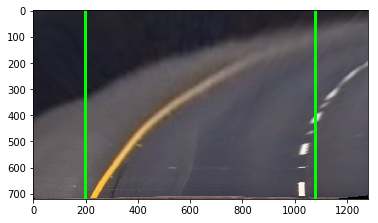

In [44]:
#plt.imshow(binary_warped)
cv2.line(binary_warped, (200, 720), (200, 0), (0, 255, 0), 10)
cv2.line(binary_warped, (1080, 720), (1080, 0), (0, 255, 0), 10)
plt.imshow(binary_warped, cmap='gray')

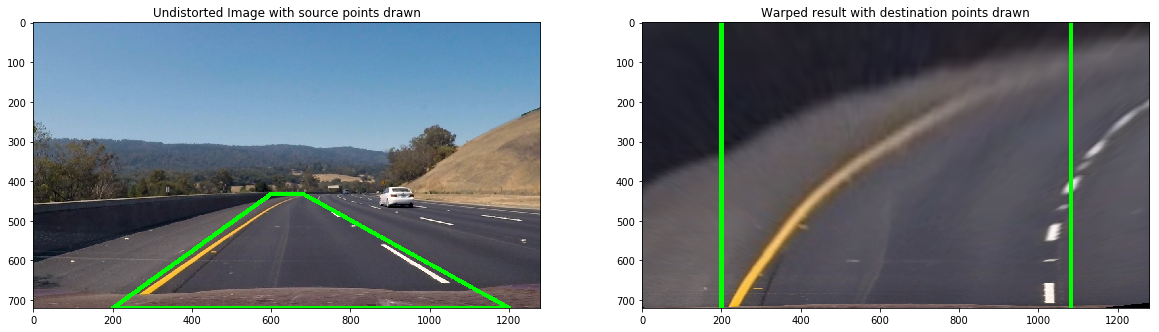

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(img_with_region_lines)
ax1.set_title('Undistorted Image with source points drawn')
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Warped result with destination points drawn')
plt.savefig('warped_binary.jpg')

## detect lane pixels

In [ ]:
def find_lane_pixels(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:, :], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    midpoint = np.int(histogram.shape[0]//2)
    
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    nwindows = 9
    margin = 100
    minpix = 50
    
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window + 1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                         (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [ ]:
def fit_polynomial(binary_warped):
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        print('The function failed to fit a line!')
        left_fitx = 1 * ploty ** 2 + 1 * ploty
        right_fitx = 1 * ploty ** 2 + 1 * ploty
        
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    # Fit a second order polynomial to each
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return out_img, left_fit, right_fit, left_fit_m, right_fit_m, ploty

In [ ]:
def space_thresh(img, thresh_min, thresh_max):
    binary = np.zeros_like(img)
    binary[(img >= thresh_min) & (img <= thresh_max)] = 1
    return binary

In [ ]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    scaled_sobel = 0
    if orient == 'x':
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    elif orient == 'y':
        scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    binary_output = np.copy(sxbinary)
    return binary_output

In [ ]:
sobelx_img = abs_sobel_thresh(binary_warped, 'x', 10, 100)
plt.imshow(sobelx_img, cmap='gray')

In [ ]:
hls_image = cv2.cvtColor(binary_warped, cv2.COLOR_BGR2HLS)
s_binary = space_thresh(hls_image[:, :, 2], 80, 255)
#plt.imshow(s_binary, cmap='gray')
out_img, left_fit, right_fit, left_fit_m, right_fit_m, proty = fit_polynomial(sobelx_img)
plt.imshow(out_img)

## Determine the curvature of the lane and vehicle position with respect to center.

In [ ]:
def calc_curve(ym, left_fit_cr, right_fit_cr, ploty):
    # Calculation of R_curve (radius of curvature)
    ym_per_pix = 30/ym
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad / 1000, right_curverad / 1000

In [ ]:
print(calc_curve(719, left_fit_m, right_fit_m, proty))

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [ ]:
def draw_line(img, left_fit, right_fit, left_fit_m, right_fit_m, plot):
    y_max = img.shape[0]
    ploty = np.linspace(0, y_max - 1, y_max)
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1]*ploty + right_fit[2]
    
    vehicle_center = img.shape[1] * xm_per_pix / 2
    #middle = left_fitx + (right_fitx - left_fitx)/2
    line_left = left_fit_m[0] * y_max * ym_per_pix  ** 2 + left_fit_m[1] * y_max * ym_per_pix  + left_fit_m[2]
    line_right = right_fit_m[0] * y_max * ym_per_pix** 2 + right_fit_m[1] * y_max * ym_per_pix  + right_fit_m[2]
    middle = (line_right + line_left)/2
    dist_from_center = middle - vehicle_center
    if dist_from_center > 0:
        message = '{:.2f} m right of center'.format(dist_from_center)
    else:
        message = '{:.2f} m left of center'.format(-1*dist_from_center)
    left, right = calc_curve(719, left_fit_m, right_fit_m, plot)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    cv2.putText(img, 'Left curvature: {:.2f} km'.format(left), (50, 50), font, 2, fontColor, 2)
    cv2.putText(img, 'Right curvature: {:.2f} km'.format(right), (50, 120), font, 2, fontColor, 2)
    cv2.putText(img, 'Vehicle is {} '.format(message), (50, 190), font, 2, fontColor, 2)
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

In [ ]:
output = draw_line(img, left_fit, right_fit, left_fit_m, right_fit_m, img.shape[0]*30/719)
plt.imshow(output)